In [1]:
from os.path import join
from os import listdir
import numpy as np
from numpy import *
import zipfile
import json
import pandas as pd
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Move Data to Local Disk

In [2]:
#mount my G Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#download and unzip
!cp drive/MyDrive/data/hirise-thumbnails/hirise-thumbnails.zip hirise-thumbnails.zip
with zipfile.ZipFile('hirise-thumbnails.zip', 'r') as zr:
    zr.extractall('hirise-thumbnails')

## Load Images and Metadata

In [4]:
#top directory for non-captioned images
tdir = join('hirise-thumbnails', 'non-captioned')

In [5]:
#read the metadata dictionary which has title strings, names, etc
with open(join(tdir, 'meta_clean.json'), 'r') as ifile:
    meta = pd.DataFrame(json.load(ifile)).T
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73143 entries, ESP_073899_2045 to TRA_000873_1780
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Acquisition date            73143 non-null  object
 1   Local Mars time             73143 non-null  object
 2   Latitude (centered)         73143 non-null  object
 3   Longitude (East)            73143 non-null  object
 4   Spacecraft altitude         73143 non-null  object
 5   Original image scale range  73143 non-null  object
 6   Map projected scale         73143 non-null  object
 7   Map projection              73143 non-null  object
 8   Emission angle              73143 non-null  object
 9   Phase angle                 73143 non-null  object
 10  Solar incidence angle       73143 non-null  object
 11  Solar longitude             73143 non-null  object
 12  North azimuth               73143 non-null  object
 13  Sub-solar azimuth          

In [6]:
#load the image file names, excluding any weird non-jpg ones
fns = [fn for fn in listdir(join(tdir, 'images')) if fn[-4:] == '.jpg']

In [7]:
#take only the image names present in metadata and file list
names = list(set(meta.index) & set([fn.replace('.jpg','') for fn in fns]))
meta = meta.loc[names]
fns = [join(tdir, 'images', name + '.jpg') for name in names]

In [8]:
images = array([imread(fn) for fn in fns], dtype=object)

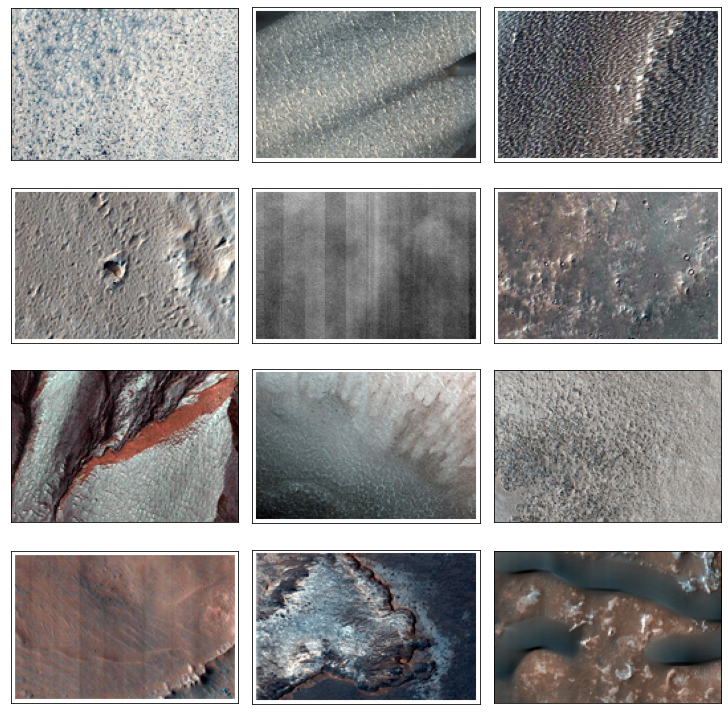

In [9]:
#plot a sample of images
fig, axs = plt.subplots(4, 3, figsize=(10,10), constrained_layout=True)
for (i,ax) in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])

## Clean Images

In [10]:
#first reject all images without exactly three channels
channels = zeros(len(images), dtype=uint8)
for i,image in enumerate(images):
    if len(image.shape) < 3:
        channels[i] = 1
    else:
        channels[i] = image.shape[2]
images = images[channels == 3]
meta = meta.loc[channels == 3]

In [11]:
#check the minimum height and width
def image_dimension_extrema(images):
    h, w = zip(*[img.shape[:2] for img in images])
    print('minimum width: ', min(w))
    print('minimum height:', min(h))
    print('maximum width: ', max(w))
    print('maximum height:', max(h))
image_dimension_extrema(images)

minimum width:  166
minimum height: 111
maximum width:  344
maximum height: 234


In [12]:
#simply crop from the center for uniform size
for i in range(len(images)):
    h, w = images[i].shape[:2]
    hc, wc = h//2, w//2
    images[i] = images[i][hc-50:hc+50,wc-75:wc+75,:]
image_dimension_extrema(images)

minimum width:  150
minimum height: 100
maximum width:  150
maximum height: 100


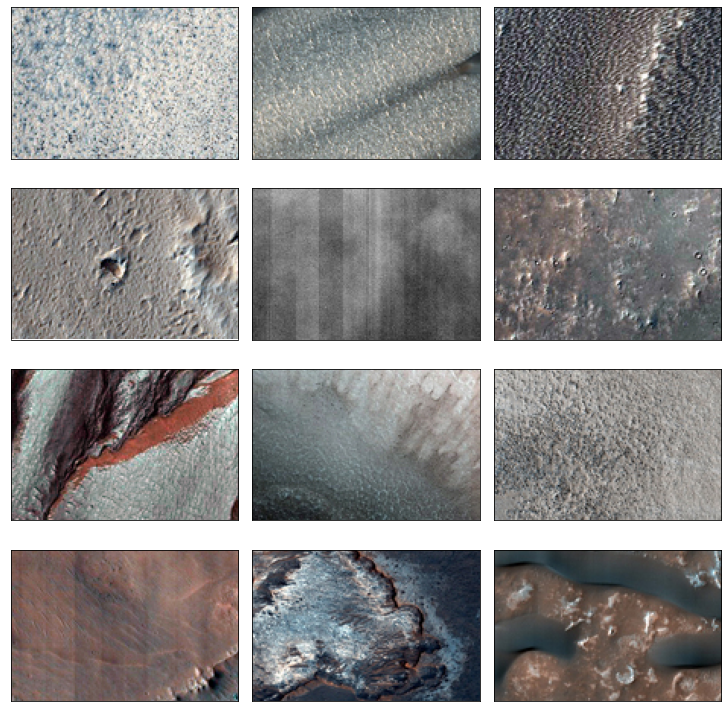

In [13]:
#plot the same sample
fig, axs = plt.subplots(4, 3, figsize=(10,10), constrained_layout=True)
for (i,ax) in enumerate(axs.flatten()):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
images[0]

array([[[202, 222, 229],
        [201, 213, 213],
        [209, 217, 220],
        ...,
        [167, 162, 159],
        [204, 204, 202],
        [205, 207, 194]],

       [[148, 161, 169],
        [180, 184, 183],
        [184, 183, 181],
        ...,
        [233, 238, 232],
        [221, 223, 218],
        [195, 192, 185]],

       [[111, 124, 130],
        [ 89, 103, 112],
        [154, 168, 177],
        ...,
        [178, 191, 184],
        [187, 197, 198],
        [222, 212, 221]],

       ...,

       [[189, 188, 193],
        [188, 194, 194],
        [138, 152, 155],
        ...,
        [155, 147, 144],
        [191, 206, 209],
        [196, 223, 230]],

       [[235, 234, 230],
        [223, 222, 202],
        [217, 207, 195],
        ...,
        [171, 169, 157],
        [193, 210, 217],
        [161, 186, 191]],

       [[210, 218, 220],
        [198, 204, 194],
        [206, 206, 194],
        ...,
        [222, 232, 223],
        [145, 155, 157],
        [120, 132, 144]]

In [15]:
#some images are completely dark in half or more of the frame, not hard to remove
def ispartiallymissing(image, thresh=0.25):
    n, m = image.shape[:2]
    b = sum(image == 0)
    if b > thresh*(3*n*m):
        return True
    return False

b = array([ispartiallymissing(images[i]) for i in range(images.shape[0])])
print('{} partially missing images'.format(sum(b)))

491 partially missing images


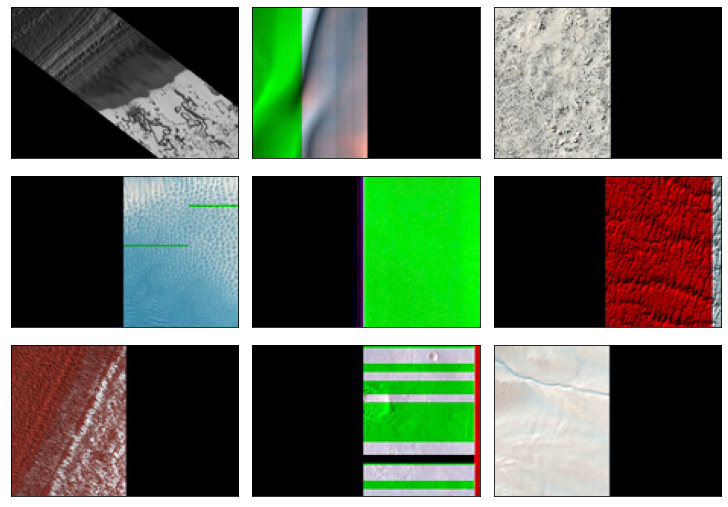

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(10,7), constrained_layout=True)
idx = flatnonzero(b)
for (i,ax) in enumerate(axs.flatten()):
    ax.imshow(images[idx[i]])
    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
#throw out the partially missing images
images = images[logical_not(b)]
meta = meta.loc[logical_not(b)]
print(images.shape, len(meta))

(71968,) 71968


## Attempt Category Extraction

In [18]:
title = meta.title.copy()
title.head()

ESP_067230_1115                  Periglacial Survey
ESP_035891_2610                 Olympia Undae Dunes
ESP_055244_1765          Monitoring New Impact Site
ESP_035240_1975    Lava Flow North of Ascraeus Mons
ESP_055711_1965              Cones in Utopia Region
Name: title, dtype: object

In [19]:
#lower and take only alphanumeric characters
clean_word = lambda s: ''.join([x.lower() for x in s if x.isalnum()])
def clean_string(s):
    #clean the individual words
    words = [clean_word(x) for x in s.split()]
    #put them back together, ignoring short words
    s = ' '.join([w for w in words if (len(w) > 2 and w != 'and' and w != 'with')])
    return(s)

In [20]:
for i in title.index:
    title.at[i] = clean_string(title.at[i])
counts = pd.value_counts((' '.join(title.values)).split())

In [21]:
title.head()

ESP_067230_1115               periglacial survey
ESP_035891_2610              olympia undae dunes
ESP_055244_1765       monitoring new impact site
ESP_035240_1975    lava flow north ascraeus mons
ESP_055711_1965              cones utopia region
Name: title, dtype: object

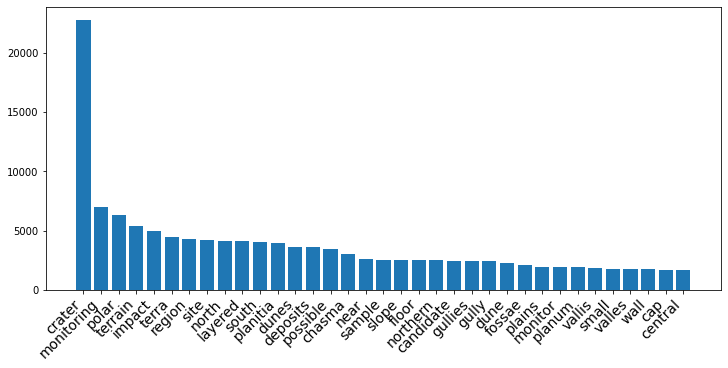

In [22]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,5))
n = 35
ax.bar(range(n), counts.values[:n])
ax.set_xticks(range(n))
ax.set_xticklabels(
    counts.index[:n],
    rotation=45,
    fontsize=14,
    ha='right'
);

In [23]:
categories = [
    'other',
    'crater',
    'impact',
    'layered',
    'dunes',
    'deposits',
    'chasma',
    'slope',
    'floor',
    'gullies',
    'fossae',
    'planum',
    'valles',
    'wall',
    'cap'
]

In [24]:
#array for attempted integer label of each image
labels = zeros(len(title), dtype=uint8)
#duplicate words to swap
sub = [
    ('gully', 'gullies'),
    ('dune', 'dunes'),
    ('plains', 'planum'),
    ('vallis', 'valles')
]
for (i,idx) in enumerate(title.index):
    s = title.at[idx]
    for (a,b) in sub:
        s = s.replace(a, b)
    for c in categories:
        if c in s:
           labels[i] = categories.index(c)
           break

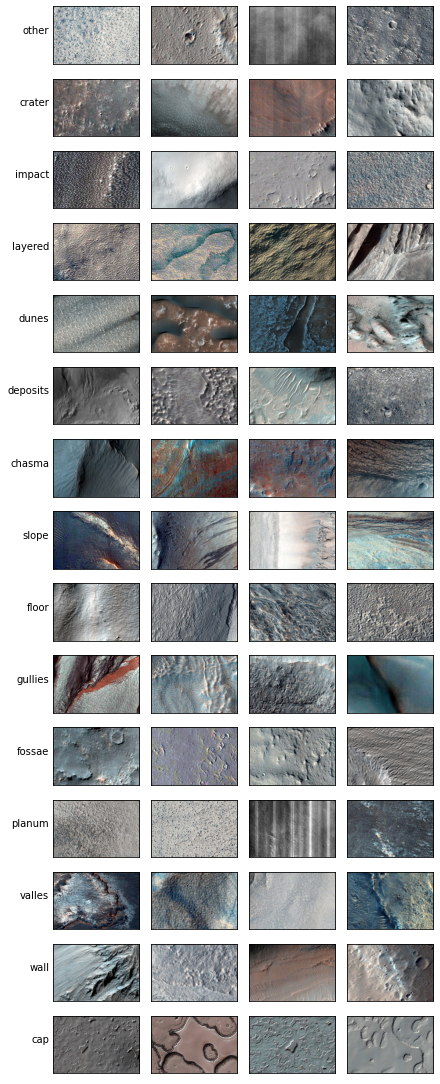

In [25]:
n = 4
fig, axs = plt.subplots(
    len(categories), n,
    figsize=(6,15),
    constrained_layout=True
)
for i in range(len(categories)):
    idx = flatnonzero(labels == i)
    axs[i,0].set_ylabel(categories[i], rotation=0, ha='right')
    for j in range(n):
        axs[i,j].imshow(images[idx[j]])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])



It doesn't look like the image titles provide good classification labels. This is for a number of reasons. The images are thumbnails cropped from much larger originals. The titles are also not usually plainly descriptive. For example, an image might be targeted at a feature inside a crater and titled something like "Deposits in Terby Crater," even though the whole crater is not visible in the image because it's much larger than the deposits.

# Save Cleaned Images/Metadata

In [26]:
#stack the images into a single array
images = stack(images)
images.shape

(71968, 100, 150, 3)

In [27]:
#save the processed image stack back to Drive for later reuse
save('drive/MyDrive/data/hirise-thumbnails/hirise_thumbnails.npy', images)

In [28]:
#save the filtered metadata back as well
meta.to_csv('drive/MyDrive/data/hirise-thumbnails/hirise_metadata.csv')